# Inception-Style Networks and the Labeled Faces in the Wild Dataset
By Benjamin Fynan  
05/13/2019  
CS344, Calvin College
## Background
### Convolutional Neural Network Layers
#### Dense
Dense layers are fully connected. Every input is connected to every node.
#### Convolutional
Convolutional layers take the dot product of a n by m sized filter and a section of the same sized section of the input. 
The filter is applied across the input, moving across the matrix with a stride determining the distance the filter moves
as the input is convolved.
#### Pooling
Pooling layers pull out the average or maximum importance elements from the input. This reduces the dimensionality of the
input without reducing the risk of overfitting and maintaining the relative position of significant features,
#### Normalization
Inputs to neural nets or outputs of other layers, such as convolutional layers may have very large or very small magnitude 
which can disproportionally blow up weights as the model is trained. Normalization layers keep all inputs between 0 and 1.

### Inception-Style Deep Neural Nets

### Inception v1
The philosophy behind the inception networks is that as neural networks get deeper, they must also get broader to prevent
“bottle necking” or information loss over dimension reduction [3].
The Inception Network combines differently sized convolutional layers to great effect. Images of the same class may have important 
characteristics of different sizes, so the Inception Network is designed to allow the network to learn what sized convolution is best [3].
The unique nature of a inception module is the combination of 1x1, 3x3, 5x5, and max pooling layers in parallel, taking from the same
input, then concatenating the outputs, thereby letting the network decide whether large features or small features are important.
Further, inception modules use 1x1 matrices for dimension reduction to reduce computational complexity. The kernel length of the 1x1
convolution layer determines the dimensionality of the output while keeping the relevant information. 
Since the network uses larger convolutions, there is an issue with
computational cost. An n x n convolution
can be factored into two separate convolutions of size 1 x n and n x 1. This is done to reduce the computational complexity
of large dimensional convolution operations.
Since Inception is a very deep network, it has an issue of vanishing gradient. To prevent stagnation in the middle of 
the network, auxiliary classifiers consisting of average pooling, convolutional, filter concatenation, and softmax activation 
layers are placed along the network at different depths[3]. 

### Inception v3
Inception version three adds 4 improvements over Inception V1. Firstly, they added was 7x7 factorized convolutional layers. 
This allows the network to learn even more advanced features than with a maximum convolution size of 5x5. The 5x5 convolutions 
were implemented with two factored 3x3 convolutional layers in series. Likewise the 7x7 convolutions 
were represented with three 3x3 convolutions. The team did this because two 3x3 convolutions are computationally cheaper than 
a single 5x5 convolution [3].  
Secondly, they implemented the RMSProp optimizer [2]. RMSProp is useful because training gradients can have a variety of slopes,
so adjusting the learning rate makes learning more efficient [4]. Thirdly, they used label smoothing to prevent overfitting. 
label smoothing penalizes any logit prediction that pulls significantly ahead of the others [2]. Finally, They implemented 
batch normalization in the auxiliary classifiers. 

## Experiments
The student was interested in exploring facial recognition and the inception network.

### Dataset
The dataset used was the Labeled Faces in the Wild (LFW) set [5]. The set contains images of the faces of famous people scrapped from
the internet. The LFW set has a minimum of two images per person, but the student used subsets choosing the classes with a 
minimum of 70 or 40 images per person for a total of 7 and 19 classes respectively. The LFW subset used had predominantly 
white, male faces. This does reduce the dimensionality of the input, which results in a less real-world dataset.


(1288, 62, 47)


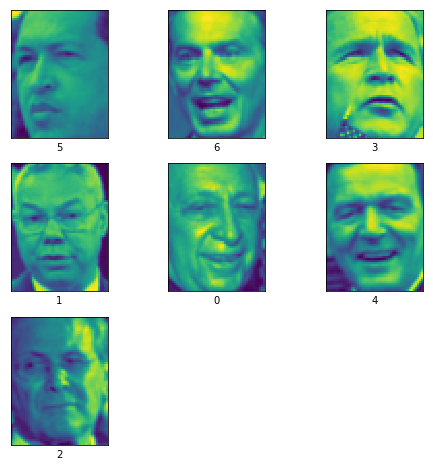

In [93]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import math


lfw_people = fetch_lfw_people(min_faces_per_person=70)

n_samples, h, w = lfw_people.images.shape

def plot_images(images, labels):
    imgs = []
    l = []
    for label, im in zip(labels, images):
        if label not in l:
            l.append(label)
            imgs.append(im)
    
    fig=plt.figure(figsize=(8, 8))
    columns = int(math.sqrt(len(imgs))) + 1
    rows = columns
    
    for (name, (i, im)) in zip(l, enumerate(imgs)):
        fig.add_subplot(rows, columns, i + 1, xlabel=name, xticks=[], yticks=[])
        plt.imshow(im)
    print(images.shape)    
    plt.show()

plot_images(lfw_people.images, lfw_people.target)


### SciKitLearn SVM 
To get a comparison of techniques on this dataset, the student ran the example designed by Scikit-learn.

#### Methods
This example uses a support vector machine for classification, grid search to optimize the gamma and C penalty parameter. 
The principle component analysis of the faces or "eigenfaces" are taken to reduce the dimensionality of the faces while 
keeping important features.


#### Results & Discussion

##### Code

In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

def svm_ex():
    print(__doc__)
    
    # Display progress logs on stdout
    logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
    
    
    # #############################################################################
    # Download the data, if not already on disk and load it as numpy arrays
    
    lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
    
    # introspect the images arrays to find the shapes (for plotting)
    n_samples, h, w = lfw_people.images.shape
    
    # for machine learning we use the 2 data directly (as relative pixel
    # positions info is ignored by this model)
    X = lfw_people.data
    n_features = X.shape[1]
    
    # the label to predict is the id of the person
    y = lfw_people.target
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]
    
    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)
    
    
    # #############################################################################
    # Split into a training set and a test set using a stratified k fold
    
    # split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    
    
    # #############################################################################
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    n_components = 150
    
    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))
    
    eigenfaces = pca.components_.reshape((n_components, h, w))
    
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    
    
    # #############################################################################
    # Train a SVM classification model
    
    print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                       param_grid, cv=5, iid=False)
    clf = clf.fit(X_train_pca, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
    
    # #############################################################################
    # Quantitative evaluation of the model quality on the test set
    
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))
    
    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    
    
    # #############################################################################
    # Qualitative evaluation of the predictions using matplotlib
    
    def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
        """Helper function to plot a gallery of portraits"""
        plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
        plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
        for i in range(n_row * n_col):
            plt.subplot(n_row, n_col, i + 1)
            plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
            plt.title(titles[i], size=12)
            plt.xticks(())
            plt.yticks(())
    
    
    # plot the result of the prediction on a portion of the test set
    
    def title(y_pred, y_test, target_names, i):
        pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
        true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
        return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
    
    prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]
    
    plot_gallery(X_test, prediction_titles, h, w)
    
    # plot the gallery of the most significative eigenfaces
    
    eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
    plot_gallery(eigenfaces, eigenface_titles, h, w)
    
    plt.show()

svm_ex()

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.668s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.020s
Fitting the classifier to the training set
done in 43.970s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.048s
                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.46      0.60        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.84      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.

<Figure size 720x720 with 12 Axes>

<Figure size 720x720 with 12 Axes>



This approach works well. Indeed, the f-scores of the classification of each class is within 0.60-0.90 with the weighted average
being 0.85.

### Network used for MNIST 
The use on a basic, shallow CNN was considered. The network designed for the MNIST example used in class was adapted to 
the LFW set.

#### Methods
The network is sequential model consisting of three convolution layers interspersed with max pooling layers. The output is flattened
and run through a hidden dense layer and finally classified with the output dense layer. The learning is optimized with 
stochastic gradient descent. The loss function used was catagorical crossentropy. The model was trained with a batch sized 
32 and 100 epochs. A quarter of the training set was split into a test set with the train_test_split() function.

#### Results & Discussion

##### Code


Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 125
n_classes: 7
target names:
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_519 (Conv2D)          (None, 123, 92, 32)       320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 61, 46, 32)        0         
_________________________________________________________________
conv2d_520 (Conv2D)          (None, 59, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 29, 22, 64)        0         
_________________________________________________________________
conv2d_521 (Conv2D)          (None, 27, 20, 64)        36928     
_______________

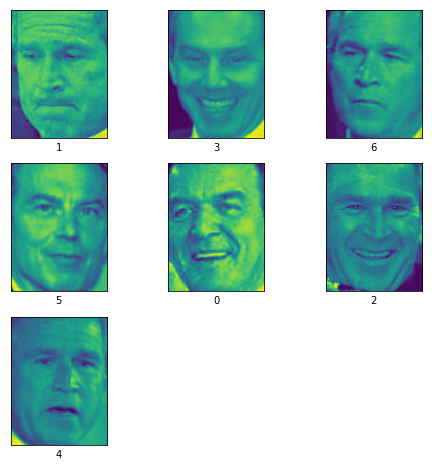

In [94]:
import numpy as np
from keras import layers
from keras import models
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

def mnist_net_ex():
    print(__doc__)
    
    # Display progress logs on stdout
    #logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
    
    
    ###############################################################################
    # Download the data, if not already on disk and load it as numpy arrays
    
    lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1)
    
    # introspect the images arrays to find the shapes (for plotting)
    n_samples, h, w = lfw_people.images.shape
    
    # for machine learning we use the 2 data directly (as relative pixel
    # positions info is ignored by this model)
    X = lfw_people.images
    n_features = X.shape[1]
    
    # the label to predict is the id of the person
    y = lfw_people.target
    
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]
    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)
    print('target names:\n', target_names)
    
    y = to_categorical(y, num_classes=n_classes)
    X = X.reshape(n_samples, h, w, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25)
    
    model = models.Sequential()
    
    # Configure a convnet with 3 layers of convolutions and max pooling.
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(h, w, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Add layers to flatten the 2D image and then do a 7-way classification.
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    model.summary()
    
    model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    print(model.evaluate(X_test, y_test))

    incorrects = np.nonzero(to_categorical(model.predict_classes(X_test).reshape((-1,)), num_classes=n_classes) != y_test)
    incrct_ims = []
    indexes = []
    for i in incorrects[0]:
        if i not in indexes:
            indexes.append(i)
            incrct_ims.append(X_test[i])
    
    incorrect_images = np.asarray(incrct_ims)
    n_samples, h, w, c = incorrect_images.shape
    incorrect_images = incorrect_images.reshape(n_samples, h, w)
    plot_images(incorrect_images, incorrects[1])
    
mnist_net_ex()

The images above are samples of misclassified images.

The maximum accuracy achieved was 0.29 on the 19 class subset after training for 100 epochs. Training for 10 epochs resulted in an 
accuracy of 0.26.
After looking at a sample of the faces which were incorrectly identified, the student noticed that 5 of 
the seven viewed had glasses. Training for fewer epochs resulted in variable results. Training on the 7 class subset 
with 10 epochs resulted in accuracies ranging from 0.18 to 0.41. Longer training ranges stabilized at 0.29.

### Inception V3
The motivation behind this experiment was to replicate the architecture used by the FaceNet team [7]. However, the student 
did not implement the triplet loss function used by Schroff et. al. The student implemented this network following
the example in the Keras applications page [8].

#### Methods
The student used the same LFW subsets of 7 classes and 19 classes. 
The base model was pretrained on the Imagenet dataset using weights downloaded through the Keras API. ImageNet contains 
images of many different concepts, so it contains many non-face images. 
One of the difficulties faced by the student was the input of the Inception V3 network. The network requires an input with 
three color channels; however, the LFW images are encoded in greyscale. This dimension mismatch was corrected with the sklearn-image 
function grey2rgb(X) which duplicates the elements across the three color channels.
#### Results & Discussion
##### Code

In [87]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

print(lfw_people.images.shape)
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.images
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

X_3chan = color.grey2rgb(X)
y = to_categorical(y, num_classes=n_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X_3chan, y, test_size=0.25)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(h,w,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer
predictions = Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

BS = 32
EPOCHS = 10

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=BS),
                     steps_per_epoch=len(X_train) / BS, epochs=EPOCHS)

# train the model on the new data for a few epochs
#model.fit(X_train, y_train, batch_size=BS, epochs=EPOCHS)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adagrad(lr=0.01, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(X_train, y_train, batch_size=BS, epochs=EPOCHS // 10)

print(model.evaluate(X_test, y_test))

Automatically created module for IPython interactive environment
(1288, 125, 94)
Total dataset size:
n_samples: 1288
n_features: 125
n_classes: 7
(966, 125, 94, 3)
(966, 7)
(322, 125, 94, 3)
(322, 7)
Epoch 1/10
31/30 [==============================] - 27s 857ms/step - loss: 2.5072 - acc: 0.3547
Epoch 2/10
31/30 [==============================] - 13s 424ms/step - loss: 1.7321 - acc: 0.3777
Epoch 3/10
31/30 [==============================] - 13s 435ms/step - loss: 1.6555 - acc: 0.4324
Epoch 4/10
31/30 [==============================] - 14s 436ms/step - loss: 1.6238 - acc: 0.4506
Epoch 5/10
31/30 [==============================] - 16s 509ms/step - loss: 1.5664 - acc: 0.4659
Epoch 6/10
31/30 [==============================] - 18s 571ms/step - loss: 1.5249 - acc: 0.4718
Epoch 7/10
31/30 [==============================] - 17s 552ms/step - loss: 1.5220 - acc: 0.4659
Epoch 8/10
31/30 [==============================] - 18s 593ms/step - loss: 1.4905 - acc: 0.4603
Epoch 9/10
31/30 [==============

Training for 100 epochs on the 19 class subset resulted in an 
accuracy of 0.27. However, the accuracy achieved on the training set was much higher. This suggests overfitting. To correct 
this, the student used image augmentation to inflate the training set. The augmentation used a rotation range of 20 degrees, 
a width shift of 0.2, a height shift of 0.2, and horizontal flip enabled. The model was retrained with the augmentation data generator, 
but the accuracy neither improved nor reduced. Training the model without the pretrained weights, with the 7 or 19 class
subsets for 10 epochs resulted in a decrease in accuracy. The non-pretrained model was trained with a 158 class set over 
100 epochs. This resulted in an accuracy of 0.12.
Initial tinkering suggested that keeping the pretrained weights resulted in higher accuracy. 

### Conclusion
The best results were achieved on the 7 class subset with the SVM, with an average f1 score of 0.85. With the 7 class subset, both the MNIST style net and 
the Inception V3 network at best achieved an accuracy of 0.4 - 0.45. The student could not determine the exact reason the SVM outperformed either the MNIST 
style or the inception network. It is possible better accuracy was achieved because the SVM classifies each sample pair pairwise. 
The SVM example also used a gridsearch to optimize the hyperperameters, where the other two networks were hand tuned. 

## Bibliography
1. Szegedy, Christian, et al. "Going deeper with convolutions." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.
2. Szegedy, Christian, et al. "Rethinking the inception architecture for computer vision." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
3. https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202
4. https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a
5. http://vis-www.cs.umass.edu/lfw/
6. https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py
7. Schroff, Florian, Dmitry Kalenichenko, and James Philbin. "Facenet: A unified embedding for face recognition and clustering." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.
8. https://keras.io/applications/
